In this example, we are performing an adversarial attack on a neural network model trained on the MNIST dataset using the Fast Gradient Sign Method (FGSM). The FGSM is a white-box attack, meaning we have access to the model's architecture and gradients. The main steps involved are as follows:

**Data preparation and model training:** We first load the MNIST dataset, define the neural network architecture (a simple Convolutional Neural Network), and train the model using the training dataset.

**Define the FGSM attack:** The FGSM attack involves creating a perturbed input image by adding a small amount of noise in the direction of the gradient of the loss function with respect to the input image. This noise can cause the model to misclassify the perturbed image. To implement the FGSM attack, we define the fgsm_attack function, which takes the input image, an epsilon value (controlling the strength of the perturbation), and the gradient of the data as input. The function returns the perturbed image.

**Test the model with FGSM adversarial examples:** We define the test_with_fgsm function to test the model's performance on adversarial examples created using FGSM. The function takes the model, test_loader, and epsilon value as input.

In the test_with_fgsm function, we perform the following steps for each input image in the test dataset:

a. Compute the initial prediction for the input image. If the initial prediction is incorrect, we skip this image and continue with the next one.

b. Calculate the loss between the predicted output and the target label.

c. Compute the gradient of the loss with respect to the input image.

d. Create a perturbed image using the fgsm_attack function.

e. Compute the final prediction for the perturbed image. If the final prediction is the same as the target label, we consider it a successful adversarial attack (i.e., the model was not fooled by the perturbation). Otherwise, we save this adversarial example for later visualization.

f. Calculate the accuracy of the model on the adversarial examples by dividing the number of correct predictions by the total number of test samples.

**Run the attack with different epsilon values:** We run the FGSM attack with different epsilon values to see how the model's accuracy is affected by the strength of the perturbation. A higher epsilon value means a stronger perturbation, which should result in a lower accuracy. We store the accuracy and adversarial examples for each epsilon value.

**Visualize results:** We plot a graph of the model's accuracy vs. epsilon values to see the effect of the perturbation strength on the model's performance. We also display some of the adversarial examples created during the FGSM attack to visualize how the perturbation affects the input images.

In summary, this code demonstrates how the Fast Gradient Sign Method (FGSM) can be used to create adversarial examples that can fool a neural network model. The strength of the perturbation can be controlled using the epsilon value, and the effect of the perturbation on the model's performance is visualized using a graph and some example images.

Epoch: 1, Accuracy: 95.67%
Epsilon: 0	Test Accuracy = 381 / 10000 = 3.81%
Epsilon: 0.05	Test Accuracy = 561 / 10000 = 5.61%
Epsilon: 0.1	Test Accuracy = 562 / 10000 = 5.62%
Epsilon: 0.15	Test Accuracy = 528 / 10000 = 5.28%
Epsilon: 0.2	Test Accuracy = 297 / 10000 = 2.97%
Epsilon: 0.25	Test Accuracy = 696 / 10000 = 6.96%
Epsilon: 0.3	Test Accuracy = 575 / 10000 = 5.75%


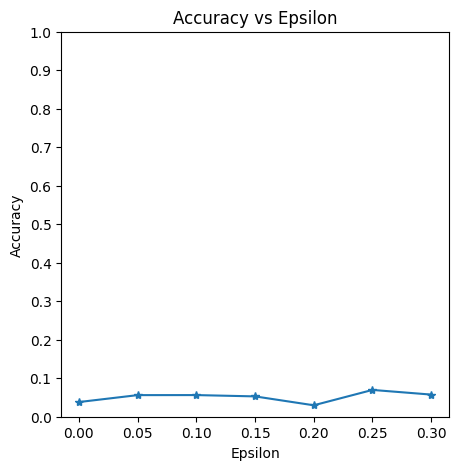

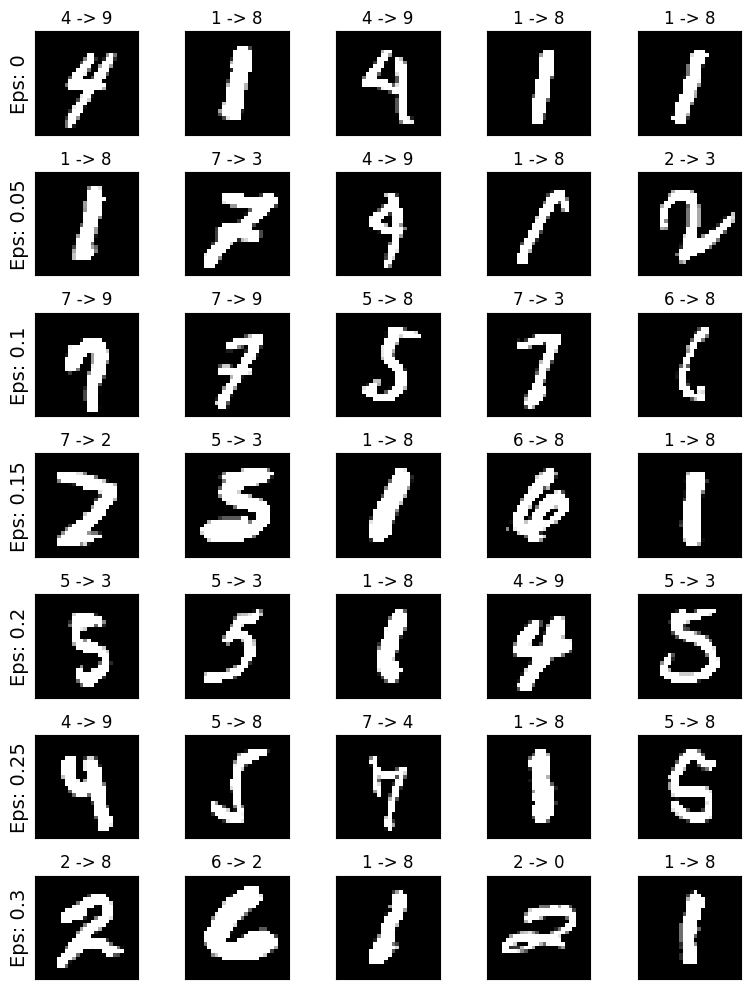

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


# Define data loader and transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize using MNIST dataset mean and std
])

# Load the MNIST dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transform),
    batch_size=64, shuffle=True)

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# Instantiate the model, optimizer, and loss function
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Train the model
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Evaluate the model
def test(model, test_loader):
    model.eval()
    correct = 0
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    return correct / len(test_loader.dataset)

# Training loop
for epoch in range(1, 2):
    train(model, train_loader, optimizer, epoch)
    accuracy = test(model, test_loader)
    print('Epoch: {}, Accuracy: {:.2f}%'.format(epoch, 100. * accuracy))

# Define the FGSM attack function
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Test the model with FGSM adversarial examples
def test_with_fgsm(model, test_loader, epsilon):
    model.eval()
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data.requires_grad = True
        output = model(data)
        init_pred = output.argmax(dim=1, keepdim=True)

        # Skip if any initial prediction is wrong
        if not torch.all(init_pred.squeeze() == target):
            continue

        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()

        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)
        final_pred = output.argmax(dim=1, keepdim=True)

        correct += torch.sum(final_pred.squeeze() == target).item()

        # Save adversarial examples
        if len(adv_examples) < 5:
            for idx in range(data.shape[0]):
                if final_pred[idx].item() != target[idx].item():
                    adv_ex = perturbed_data[idx].squeeze().detach().numpy()
                    adv_examples.append((init_pred[idx].item(), final_pred[idx].item(), adv_ex))
                    if len(adv_examples) >= 5:
                        break

    final_accuracy = correct / len(test_loader.dataset)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {:.2f}%".format(epsilon, correct, len(test_loader.dataset), 100. * final_accuracy))

    return final_accuracy, adv_examples


# Run the FGSM attack with different epsilon values
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test_with_fgsm(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

# Plot the accuracy vs. epsilon
plt.figure(figsize=(5, 5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Display some adversarial examples
count = 0
plt.figure(figsize=(8, 10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        count += 1
        plt.subplot(len(epsilons), len(examples[0]), count)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()



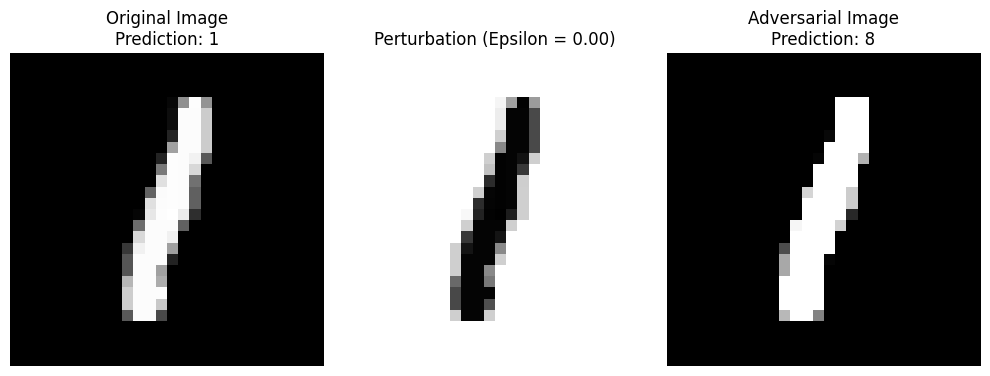

Epsilon: 0	Test Accuracy = 628 / 10000 = 6.28%


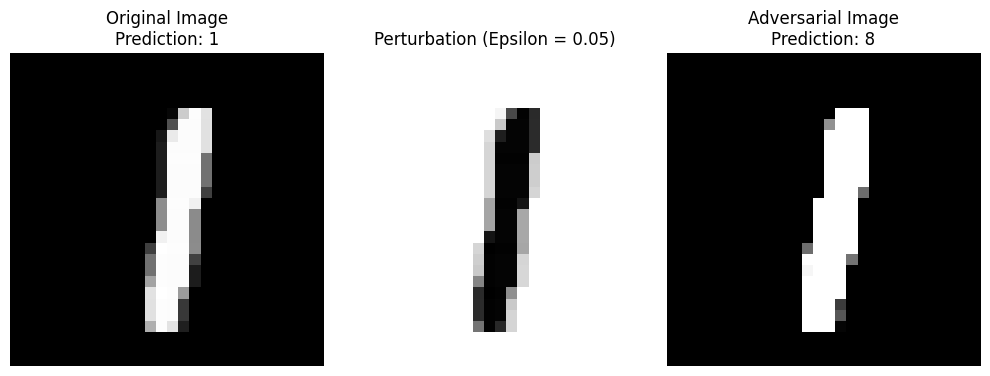

Epsilon: 0.05	Test Accuracy = 811 / 10000 = 8.11%


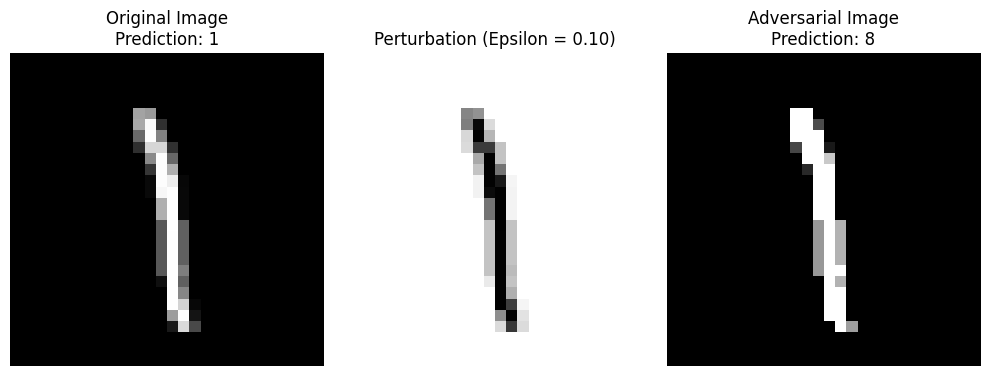

Epsilon: 0.1	Test Accuracy = 607 / 10000 = 6.07%


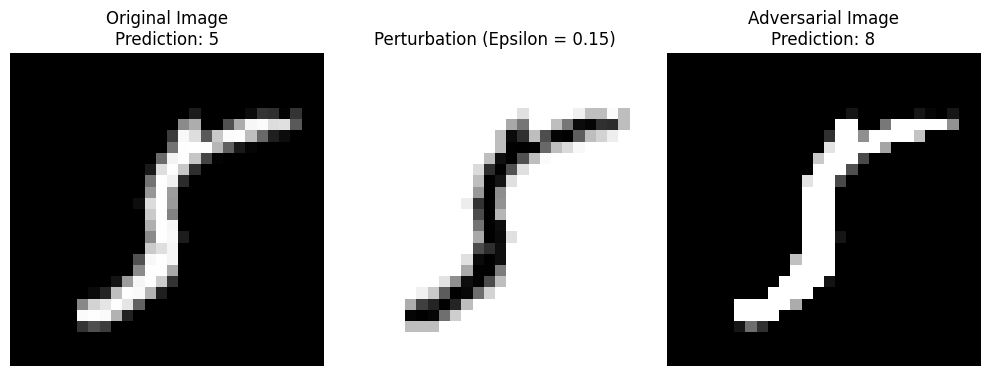

Epsilon: 0.15	Test Accuracy = 560 / 10000 = 5.60%


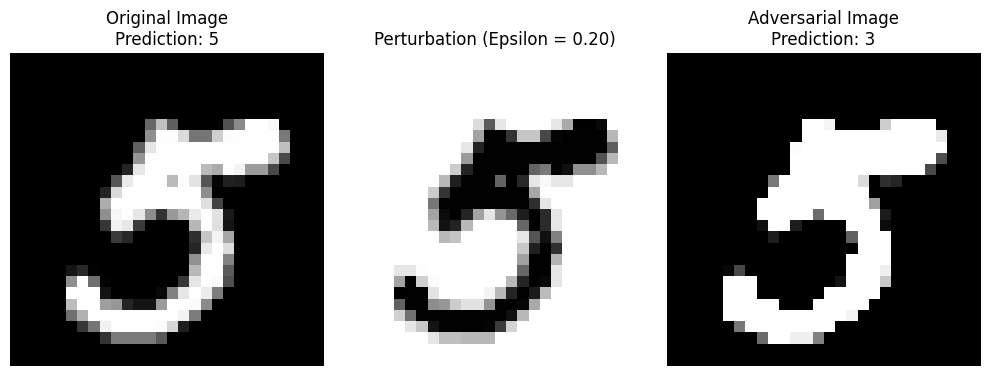

Epsilon: 0.2	Test Accuracy = 362 / 10000 = 3.62%


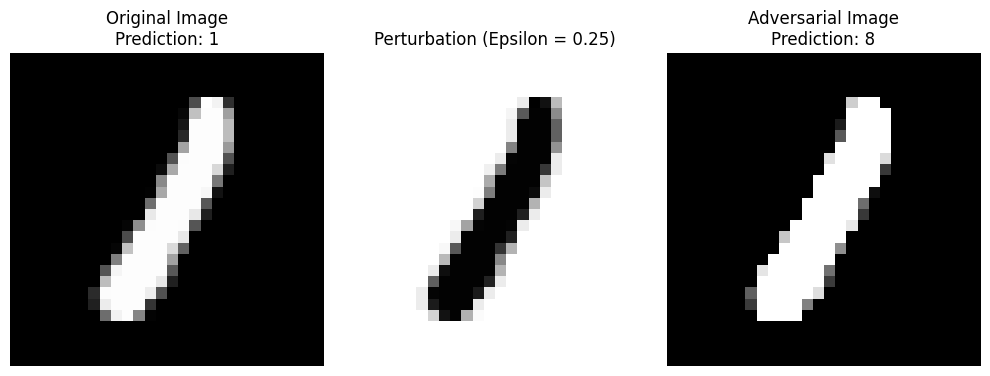

Epsilon: 0.25	Test Accuracy = 638 / 10000 = 6.38%


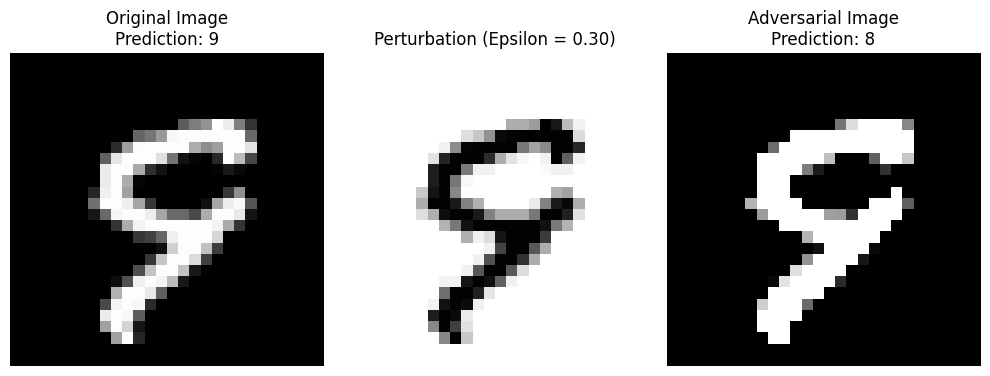

Epsilon: 0.3	Test Accuracy = 634 / 10000 = 6.34%


In [4]:
import matplotlib.pyplot as plt

def display_images(orig, perturbed, eps, init_pred, final_pred):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # Original image
    axes[0].imshow(orig, cmap='gray')
    axes[0].set_title("Original Image\nPrediction: {}".format(init_pred))
    axes[0].axis('off')

    # Perturbation
    axes[1].imshow(perturbed - orig, cmap='gray')
    axes[1].set_title("Perturbation (Epsilon = {:.2f})".format(eps))
    axes[1].axis('off')

    # Adversarial image
    axes[2].imshow(perturbed, cmap='gray')
    axes[2].set_title("Adversarial Image\nPrediction: {}".format(final_pred))
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Test the model with FGSM adversarial examples and visualize the results
def test_with_fgsm_visualization(model, test_loader, epsilon):
    model.eval()
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data.requires_grad = True
        output = model(data)
        init_pred = output.argmax(dim=1, keepdim=True)

        if not torch.all(init_pred.squeeze() == target):
            continue

        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()

        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)
        final_pred = output.argmax(dim=1, keepdim=True)

        correct += torch.sum(final_pred.squeeze() == target).item()

        # Save and display one adversarial example
        if len(adv_examples) < 1:
            for idx in range(data.shape[0]):
                if final_pred[idx].item() != target[idx].item():
                    orig = data[idx].squeeze().detach().numpy()
                    adv_ex = perturbed_data[idx].squeeze().detach().numpy()
                    display_images(orig, adv_ex, epsilon, init_pred[idx].item(), final_pred[idx].item())
                    adv_examples.append((init_pred[idx].item(), final_pred[idx].item(), adv_ex))
                    break

    final_accuracy = correct / len(test_loader.dataset)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {:.2f}%".format(epsilon, correct, len(test_loader.dataset), 100. * final_accuracy))

    return final_accuracy, adv_examples

# Run the FGSM attack with different epsilon values and visualize the results
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test_with_fgsm_visualization(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
